In [15]:
# Importing necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import openpyxl

In [16]:
# Directory setup
gp2_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
output_analysis_dir = os.path.join(gp2_dir, 'Distribution Analysis', 'Output Analysis')
assert output_analysis_dir == os.getcwd(), f"Expected output_analysis_dir to be the current working directory."
figures_dir = os.path.join(gp2_dir, 'Report', 'Figures', 'Distribution Analysis', 'Initial Output Analysis')
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
laptop_timings_xlsx = os.path.join(output_analysis_dir, '300_weeks_improved', 'laptop_timings.xlsx')
assert os.path.exists(laptop_timings_xlsx), f"Expected {laptop_timings_xlsx} to exist."

# Analysis of Laptop Timings from improved simulation

In [17]:
# Importing the laptop timings data
laptop_timings = pd.read_excel(laptop_timings_xlsx)

/opt/homebrew/anaconda3/envs/Group_Project_2/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


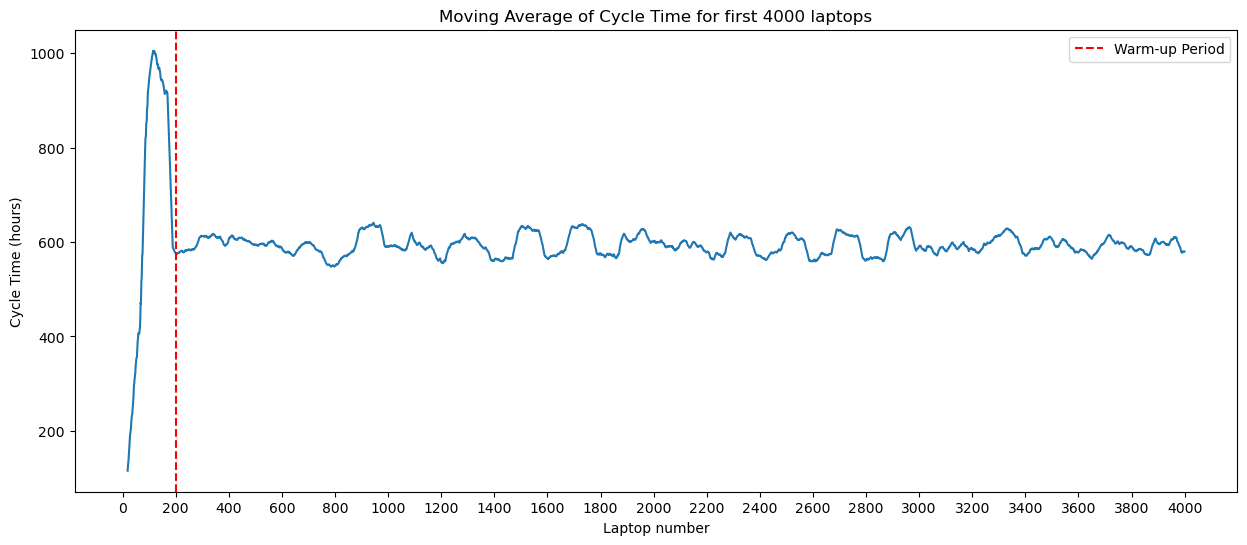

In [18]:
# plot the moving average of the cycle time
N = len(laptop_timings)
max_laptop_count = 4000
plot_tick_step = int(max_laptop_count / 20)
ticks = range(0, max_laptop_count + plot_tick_step, int(max_laptop_count / 20))
moving_average_window = 20
laptop_timings['moving_average'] = laptop_timings['cycle_time'].rolling(window=moving_average_window).mean()
plt.figure(figsize=(15, 6))
plt.plot(laptop_timings['moving_average'][:max_laptop_count])
plt.title(f'Moving Average of Cycle Time for first {max_laptop_count} laptops')
plt.xlabel('Laptop number')
plt.ylabel('Cycle Time (hours)')
plt.xticks(ticks=ticks, labels=ticks)
warm_up_period = 200
plt.axvline(x=warm_up_period, color='red', linestyle='--', label='Warm-up Period')
plt.legend()
plt.savefig(os.path.join(figures_dir, 'moving_average_cycle_time_improved.png'), dpi=300)
plt.show()

In [19]:
# Define the time window for the analysis as twice the warm-up period
time_window = 2 * warm_up_period

# Determine the number of time windows for the analysis
laptop_timings_split = []
for i in range(warm_up_period, N, time_window):
    laptop_timings_split.append(laptop_timings.iloc[i:i + time_window])

print(f"Number of available time windows: {len(laptop_timings_split)}")
laptop_timings_split[0].head()

Number of available time windows: 321


,order_num,laptop_num,arrival_time,completion_time,cycle_time,shipped_time,moving_average
200,177,201,1122.654332,1692.027690,569.373359,1479.340154,576.622170
201,177,202,1122.654332,1690.955985,568.301653,1698.728575,575.278297
202,178,203,1123.002627,1700.631685,577.629058,1661.410522,574.572787
203,178,204,1123.002627,1707.735038,584.732412,1714.557809,574.947553
204,179,205,1139.101432,1717.465708,578.364276,1685.925618,574.546296


In [20]:
# Run the m_0 replications
m0 = 5

def get_cycle_time_mean(split):
    return split['cycle_time'].mean()

cycle_time_means = list(map(get_cycle_time_mean, laptop_timings_split))
Y_is = []
for i in range(m0):
    Y_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
Y_bar = sum(Y_is) / m0
s2_m0 = sum([(Y_i - Y_bar) ** 2 for Y_i in Y_is]) / (m0 - 1)
s_m0 = s2_m0 ** 0.5
print(f"Y_bar: {Y_bar:.2f} minutes, s_m0: {s_m0:.2f} minutes")

# Calculate sample eps
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2)
eps = z * s_m0 / m0
print(f"epsilon: {eps:.2f} minutes")

# solve for m
def get_m(m0, s_m0, eps, alpha):
    n = m0
    while True:
        t = stats.t.ppf(1 - alpha / 2, n - 1)
        s2_n = s_m0 ** 2 * m0 / n
        if n >= (t ** 2 * s2_n) / (eps ** 2):
            break
        n += 1
    return n
m = get_m(m0, s_m0, 0.01*Y_bar, alpha)
print(f"Number of replications needed: {m}")

X_is = []
for i in range(m):
    X_is.append(cycle_time_means.pop(0))

# Calculate the mean and standard deviation of the cycle time means
X_bar = sum(X_is) / m
s2_m = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
s_m = s2_m ** 0.5
print(f"X_bar: {X_bar:.2f} minutes, s_m: {s_m:.2f} minutes")
t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
epsilon = t_alpha * s_m / m
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon

print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"The half width of the confidence interval is {epsilon:.2f} minutes")

Y_bar: 594.62 minutes, s_m0: 4.64 minutes
epsilon: 1.82 minutes
Number of replications needed: 5
X_bar: 592.51 minutes, s_m: 1.84 minutes
Confidence interval: [591.49, 593.53] minutes
The half width of the confidence interval is 1.02 minutes


In [21]:
cycle_time_means = list(map(get_cycle_time_mean, laptop_timings_split))

desired_precision = 0.01 * Y_bar
m0 = 5
X_is = []
for i in range(m0):
    X_is.append(cycle_time_means.pop(0))

while True:
    m = m0
    X_bar = sum(X_is) / m
    s2 = sum([(X_i - X_bar) ** 2 for X_i in X_is]) / (m - 1)
    s = s2 ** 0.5
    t_alpha = stats.t.ppf(1 - alpha / 2, m - 1)
    epsilon = t_alpha * s / m
    if epsilon <= desired_precision:
        break
    m += 1
    X_is.append(cycle_time_means.pop(0))
lower_bound = X_bar - epsilon
upper_bound = X_bar + epsilon
print(f"Confidence interval: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")
print(f"Number of replications needed: {m}")

Confidence interval: [592.04, 597.20] minutes
Number of replications needed: 5
